<a href="https://colab.research.google.com/github/MiKatre/recommendations-api/blob/notebook-0/p6_interpr%C3%A9tation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'cinetimes/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Fetch data

###### Set env

In [0]:
#import os
#os.environ['SQLALCHEMY_DATABASE_URL'] = ""

###### Movie lens 20M



In [0]:
import urllib.request
import zipfile

url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
path = Path(base_dir + 'data/')

path.mkdir(parents=True, exist_ok=True)
dest_zip = path/'ml-20m.zip'
dest_unzip = path/'ml-20m'

if not dest_unzip.exists():
  print('Downloading and extracting files...')
  urllib.request.urlretrieve(url, dest_zip)

  with zipfile.ZipFile(dest_zip, 'r') as ref:
    ref.extractall(path)

  print('Removing zip file...')
  dest_zip.unlink()
  print('Done !')

else:
  print('Files already downloaded...')

path = dest_unzip

Files already downloaded...


###### Database

In [0]:
# !pip install mysqlclient
# from sqlalchemy import create_engine
# from sqlalchemy.ext.declarative import declarative_base
# from sqlalchemy.orm import sessionmaker

In [0]:
# SQLALCHEMY_DATABASE_URL=os.environ.get('SQLALCHEMY_DATABASE_URL')
# engine = create_engine(SQLALCHEMY_DATABASE_URL)
# Session = sessionmaker(autocommit=False, autoflush=False, bind=engine)
# session = Session()

## Train the model

In [0]:
ratings = pd.read_csv(base_dir + 'cinetimes-dataset.csv')

Join the movie names according the imdbId in the dataset


In [0]:
def add_tt(movie_id):
    return f"tt{movie_id}"

external_ids = pd.read_csv(base_dir + 'data/ml-20m/links.csv', converters={'imdbId': str, 'tmdbId': str})
movies = pd.read_csv(base_dir + 'data/ml-20m/movies.csv')
external_ids['imdbId'] = external_ids['imdbId'].apply(add_tt)

external_ids = external_ids.merge(movies, left_on='movieId', right_on='movieId')
ratings = ratings.merge(external_ids, left_on='imdbId', right_on='imdbId')

In [0]:
ratings.head()

,imdbId,rating,userId,movieId,tmdbId,title,genres
0,tt0113497,3.5,9999991,2,8844,Jumanji (1995),Adventure|Children|Fantasy
1,tt0113497,3.0,9999995,2,8844,Jumanji (1995),Adventure|Children|Fantasy
2,tt0113497,3.0,99999913,2,8844,Jumanji (1995),Adventure|Children|Fantasy
3,tt0113497,3.0,99999929,2,8844,Jumanji (1995),Adventure|Children|Fantasy
4,tt0113497,3.0,99999934,2,8844,Jumanji (1995),Adventure|Children|Fantasy


In [0]:
# Change column order to fit CollabDataBunch
ratings = ratings[['userId', 'imdbId','rating', 'title']]
ratings.head()

,userId,imdbId,rating,title
0,9999991,tt0113497,3.5,Jumanji (1995)
1,9999995,tt0113497,3.0,Jumanji (1995)
2,99999913,tt0113497,3.0,Jumanji (1995)
3,99999929,tt0113497,3.0,Jumanji (1995)
4,99999934,tt0113497,3.0,Jumanji (1995)


In [0]:
# Comment if you want the full dataset
#smaller_ratings = ratings[10000000:]
# smaller_ratings = ratings[-5000000:] # Last 5M
# ratings = smaller_ratings
# ratings.tail()

In [0]:
len(ratings)

5000039

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, bs=128, item_name='title')

In [0]:
data.show_batch()

userId,title,target
99999920453,Rudy (1993),4.0
99999921543,"King of Comedy, The (1983)",3.5
99999925235,"Piano, The (1993)",3.0
99999916984,"Birdcage, The (1996)",4.0
9999998647,Texas Chainsaw Massacre: The Next Generation (a.k.a. The Return of the Texas Chainsaw Massacre) (1994),2.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


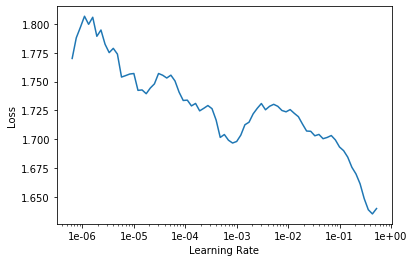

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.832669,0.833946,08:01
1,0.855373,0.841981,08:02
2,0.781920,0.806362,08:03
3,0.763439,0.753817,08:05
4,0.712153,0.730180,08:06


In [0]:
learn.save('testmodel')

In [0]:
learn.save(base_dir + 'testmodel')

In [0]:
# Export for production
# learn.export(base_dir + '/prodmodel-2')

In [0]:
learn.load(base_dir + '/testmodel')
#learn = load_learner(base_dir, 'prodmodel.pth')

CollabLearner(data=TabularDataBunch;

Train: LabelList (4500036 items)
x: CollabList
userId 9999991; title Jumanji (1995); ,userId 9999995; title Jumanji (1995); ,userId 99999913; title Jumanji (1995); ,userId 99999929; title Jumanji (1995); ,userId 99999934; title Jumanji (1995); 
y: FloatList
3.5,3.0,3.0,3.0,3.0
Path: .;

Valid: LabelList (500003 items)
x: CollabList
userId 9999993365; title 28 Days Later (2002); ,userId 99999929464; title Donnie Darko (2001); ,userId 9999991244; title Austin Powers in Goldmember (2002); ,userId 99999910793; title Legends of the Fall (1994); ,userId 99999930825; title My Own Private Idaho (1991); 
y: FloatList
3.5,4.5,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(34401, 40)
  (i_weight): Embedding(20032, 40)
  (u_bias): Embedding(34401, 1)
  (i_bias): Embedding(20032, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True,

## Prédictions

In [0]:
# # Only keep my users
# all_users = ratings.loc[ratings['userId'] < 999999]

# # Get array of users id
# my_users = all_users['userId'].unique()

# # Get array of all movies id
# all_movie_ids = ratings['imdbId'].unique()

# data = []
# for user_id in my_users:
#   # Get list of all movies rated by the userId
#   user_rated_rows = ratings.loc[ratings['userId'] == user_id]
#   user_rated_ids = user_rated_rows['imdbId'].unique()
  
#   # Remove the movie_ids that user_x has rated from the list of all movie ids
#   movie_ids_to_pred = np.setdiff1d(all_movie_ids, user_rated_ids)
  
#   # Create a dataframe with movies not rated by user
  
#   for movie_id in movie_ids_to_pred:
#     data.append({
#         'userId': user_id,
#         'imdbId': movie_id,
#         'rating': None,
#     })
  
# df_to_predict = pd.DataFrame(data=data)

# print(df_to_predict.head())


   userId     imdbId rating
0    1162  tt0000005   None
1    1162  tt0000010   None
2    1162  tt0000012   None
3    1162  tt0000014   None
4    1162  tt0000417   None


In [0]:
# my_users

array([1162, 1283, 1161, 1406, 1405])

In [0]:
# # Predict
# predictions = []
# for idx in range(len(df_to_predict)):
#   row = df_to_predict.iloc[idx]
#   movie_id = row['imdbId']
#   user_id = row['userId']
#   y, pred, raw_pred = learn.predict(row)
#   prediction = {'userId': user_id, 'movie_id': movie_id, 'prediction': pred.item()}
#   predictions.append(prediction)
#   if pred.item() > 4.0: 
#     print(movie_id, pred.item())

tt0068646 4.064924240112305
tt0102926 4.070297718048096
tt0111161 4.37367057800293
tt0114814 4.1719818115234375
tt0111161 4.012946128845215
tt0111161 4.081221580505371
tt0111161 4.0153093338012695


In [0]:
# # Sort predictions
# full_predictions = pd.DataFrame(predictions)
# sorted_predictions = full_predictions.sort_values(by='prediction', ascending=False)

In [0]:
# sorted_predictions

,userId,movie_id,prediction
8363,1162,tt0111161,4.373671
8822,1162,tt0114814,4.171982
49154,1161,tt0111161,4.081222
7428,1162,tt0102926,4.070298
3831,1162,tt0068646,4.064924
...,...,...,...
9676,1162,tt0120185,2.212290
31196,1283,tt0185183,2.208998
9325,1162,tt0118665,2.188134
92401,1405,tt0185183,2.144603


Store predictions

In [0]:
# TO ERASE. Uncomment if you lost your mind or you know what you are doing (load my previous predictions)
# sorted_predictions = pd.read_csv(root_dir + '/predictions.csv')

In [0]:
# sorted_filtered_predictions = sorted_predictions[0:0]
# for user_id in my_users:
#   this_user_df = sorted_predictions.loc[sorted_predictions['userId'] == user_id]
#   # Limit to the 500 first recommendations
#   this_user_df = this_user_df[0:500]
#   sorted_filtered_predictions = sorted_filtered_predictions.append(this_user_df)

In [0]:
# len(sorted_filtered_predictions)

2500

In [0]:
# sorted_filtered_predictions.to_csv(index=False, path_or_buf=root_dir + '/predictions.csv')

## Interprétation

In [0]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]
learn.get_idx(arr=top_movies, is_item=True)

tensor([14194,  6561, 15694, 15859,  9570, 16542,  2635, 17369, 11440, 15348,
        18117,  6791,  1076, 16544,  8947, 18671,  1646, 16543,   817, 18371,
        14374,  6085,  4393, 18306, 15552,  1450, 16379,   617,  7216,  6225,
        15976, 10530,   423, 10766, 15288, 11796, 11555,  1758, 11398, 17372,
        10768,  4936, 12110, 14006,  7145, 11933, 14058,  1649,  5435, 17944,
        18407,  1396,  5391, 15810,  7549, 16555,  8957, 10767, 14906,   665,
         4934,  2240, 11537, 13066, 16539,  7048,  7025,  7283,  3686, 16041,
         7341, 19503,  8258,  6599,  6219,   682,  9065, 14643, 19080,  7217,
         1823, 19770,  9978,  7363,  3740, 16533, 13254, 10996, 13766,  6305,
          135,  4219,  3711,  3697, 12494, 17284, 18313, 15647, 14382,  1327,
        17657,   806,  3177,  7942, 18153,  6268,  7005, 16401, 12910, 11922,
        11727, 12447,  4182,  5241, 19614, 15739,  3691,   850, 19325,  1074,
         6194,   837, 18118,  5777,  2121,  9363,  2765,  9547, 

### Movie bias

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [0]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3162), 'Speed 2: Cruise Control (1997)', 1.8675918979744937),
 (tensor(-0.2922), 'Super Mario Bros. (1993)', 2.0309888579387185),
 (tensor(-0.2312), 'Anaconda (1997)', 2.0959774170783345),
 (tensor(-0.2198), 'Batman & Robin (1997)', 2.1801339285714287),
 (tensor(-0.2101), 'Showgirls (1995)', 2.2511061946902653),
 (tensor(-0.1849), 'Wild Wild West (1999)', 2.320194384449244),
 (tensor(-0.1753), 'Godzilla (1998)', 2.2878048780487803),
 (tensor(-0.1747), 'Richie Rich (1994)', 2.39177657098526),
 (tensor(-0.1711), 'Flintstones, The (1994)', 2.4488286066584464),
 (tensor(-0.1589), 'Striptease (1996)', 2.416131792896876),
 (tensor(-0.1425),
  'Ace Ventura: When Nature Calls (1995)',
  2.6078507578701906),
 (tensor(-0.1398), 'Scream 3 (2000)', 2.455784574468085),
 (tensor(-0.1329), 'Home Alone 2: Lost in New York (1992)', 2.453235294117647),
 (tensor(-0.1282), "Dude, Where's My Car? (2000)", 2.4435674822415154),
 (tensor(-0.1264),
  'I Know What You Did Last Summer (1997)',
  2.46

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.9796), 'Shawshank Redemption, The (1994)', 4.450886075949367),
 (tensor(0.8052), 'Usual Suspects, The (1995)', 4.347230519757617),
 (tensor(0.8015), "Schindler's List (1993)", 4.307224122841912),
 (tensor(0.7500), 'Silence of the Lambs, The (1991)', 4.180525373897482),
 (tensor(0.7081), 'Godfather, The (1972)', 4.347281553398059),
 (tensor(0.6891),
  'Star Wars: Episode IV - A New Hope (1977)',
  4.192349886637899),
 (tensor(0.6769), 'Forrest Gump (1994)', 4.0296094459582195),
 (tensor(0.6726), 'Fugitive, The (1993)', 3.97530262409619),
 (tensor(0.6710), 'Braveheart (1995)', 4.042618530447157),
 (tensor(0.6629), 'Pulp Fiction (1994)', 4.16751481769742),
 (tensor(0.6539),
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  4.21310420878515),
 (tensor(0.6238), 'Matrix, The (1999)', 4.177908151371513),
 (tensor(0.6195), "One Flew Over the Cuckoo's Nest (1975)", 4.255806148476306),
 (tensor(0.6070), 'Seven (a.k.a. Se7en) (1995)', 4.0591257238931

### Movie weights

In [0]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [0]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.6730), 'Independence Day (a.k.a. ID4) (1996)'),
 (tensor(1.6201), 'Net, The (1995)'),
 (tensor(1.5638), 'Twister (1996)'),
 (tensor(1.5435), 'Under Siege 2: Dark Territory (1995)'),
 (tensor(1.5256), 'Armageddon (1998)'),
 (tensor(1.5155), 'Congo (1995)'),
 (tensor(1.5124), 'Eraser (1996)'),
 (tensor(1.4967), 'Speed 2: Cruise Control (1997)'),
 (tensor(1.4808), 'First Knight (1995)'),
 (tensor(1.4109), 'Specialist, The (1994)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.6536),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (tensor(-1.5151), 'Citizen Kane (1941)'),
 (tensor(-1.4895), 'Clockwork Orange, A (1971)'),
 (tensor(-1.4808), 'Annie Hall (1977)'),
 (tensor(-1.4577), 'Third Man, The (1949)'),
 (tensor(-1.4309), 'Apocalypse Now (1979)'),
 (tensor(-1.4150), 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (tensor(-1.4085), 'Chinatown (1974)'),
 (tensor(-1.3920), 'Raging Bull (1980)'),
 (tensor(-1.3866), 'Godfather: Part II, The (1974)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.6099), 'Fight Club (1999)'),
 (tensor(1.1047), 'Pulp Fiction (1994)'),
 (tensor(1.0763), 'Sin City (2005)'),
 (tensor(1.0425), 'Matrix, The (1999)'),
 (tensor(0.9996), 'Fear and Loathing in Las Vegas (1998)'),
 (tensor(0.9721), 'Snatch (2000)'),
 (tensor(0.9335), 'Dark Knight, The (2008)'),
 (tensor(0.9290), 'Natural Born Killers (1994)'),
 (tensor(0.8943), 'Lock, Stock & Two Smoking Barrels (1998)'),
 (tensor(0.8922), 'From Dusk Till Dawn (1996)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.6268), 'Babe (1995)'),
 (tensor(-1.4489), 'Beauty and the Beast (1991)'),
 (tensor(-1.3223), 'Sense and Sensibility (1995)'),
 (tensor(-1.2726), 'Snow White and the Seven Dwarfs (1937)'),
 (tensor(-1.2648), 'Sound of Music, The (1965)'),
 (tensor(-1.1534), 'Sleepless in Seattle (1993)'),
 (tensor(-1.1476), 'Wizard of Oz, The (1939)'),
 (tensor(-1.1284), 'To Kill a Mockingbird (1962)'),
 (tensor(-1.0673), 'Shakespeare in Love (1998)'),
 (tensor(-1.0566), 'Casablanca (1942)')]

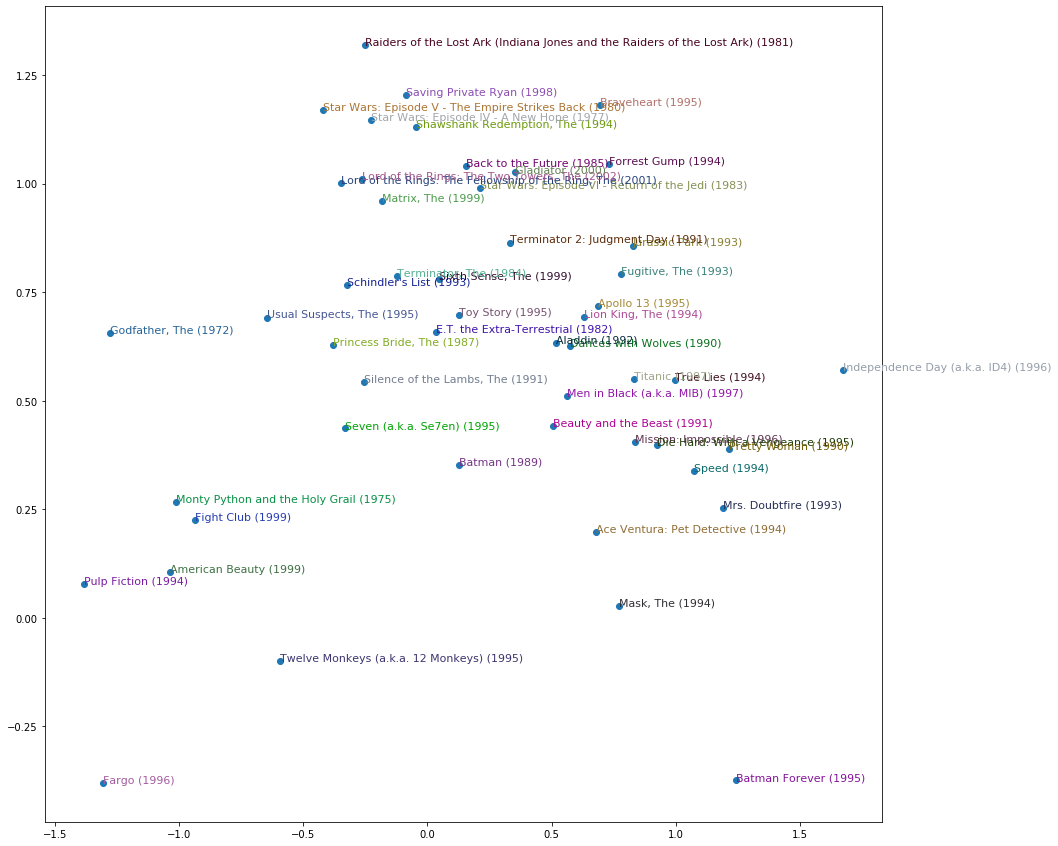

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()